# 0.1 Imports

In [23]:
!pip install keras_tuner

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
from typing import Dict, List, Tuple, Sequence
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline

# 1. Data Import & Cleaning

In [25]:
current_dir = os.getcwd()
current_dir

'/home/anita/code/MadMax1995bb/powder_alert2.0/notebooks'

In [26]:
relative_path = os.path.dirname(current_dir)
relative_path

'/home/anita/code/MadMax1995bb/powder_alert2.0'

In [27]:
file_name = "raw_data/raw_fitting.csv"

file_path = os.path.join(relative_path, file_name)

df = pd.read_csv(file_path, parse_dates=['date'], usecols=lambda col: col != '')

In [28]:
# Drop the first weird column if it exists
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

In [29]:
df.shape

(131496, 23)

In [30]:
df.columns

Index(['date', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'precipitation', 'rain', 'snowfall', 'snow_depth', 'weather_code',
       'pressure_msl', 'surface_pressure', 'cloud_cover', 'cloud_cover_low',
       'cloud_cover_mid', 'cloud_cover_high', 'et0_fao_evapotranspiration',
       'vapour_pressure_deficit', 'wind_speed_10m', 'wind_speed_100m',
       'wind_direction_10m', 'wind_direction_100m', 'wind_gusts_10m',
       'sunshine_duration'],
      dtype='object')

In [31]:
df.dtypes

date                          datetime64[ns]
temperature_2m                       float64
relative_humidity_2m                 float64
dew_point_2m                         float64
precipitation                        float64
rain                                 float64
snowfall                             float64
snow_depth                           float64
weather_code                         float64
pressure_msl                         float64
surface_pressure                     float64
cloud_cover                          float64
cloud_cover_low                      float64
cloud_cover_mid                      float64
cloud_cover_high                     float64
et0_fao_evapotranspiration           float64
vapour_pressure_deficit              float64
wind_speed_10m                       float64
wind_speed_100m                      float64
wind_direction_10m                   float64
wind_direction_100m                  float64
wind_gusts_10m                       float64
sunshine_d

In [32]:
df.tail(2)

,date,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,snowfall,snow_depth,weather_code,pressure_msl,...,cloud_cover_mid,cloud_cover_high,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,wind_gusts_10m,sunshine_duration
131494,2024-01-01 22:00:00,-13.721,80.381676,-16.371,0.0,0.0,0.0,1.23,3.0,1016.9,...,2.0,100.0,0.0,0.041773,6.763786,12.429127,154.79890,190.00792,26.28,0.679
131495,2024-01-01 23:00:00,-13.421,78.443700,-16.371,0.0,0.0,0.0,1.23,1.0,1015.7,...,0.0,40.0,0.0,0.047036,6.439876,12.605142,153.43501,181.63654,27.00,0.679


## 1.1 Splitting and scaling

In [33]:
df = df.drop_duplicates()
df = df.dropna()
df['date'] = pd.to_datetime(df['date'])

In [34]:
df.head()

,date,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,snowfall,snow_depth,weather_code,pressure_msl,...,cloud_cover_mid,cloud_cover_high,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,wind_gusts_10m,sunshine_duration
0,2009-01-01 00:00:00,-10.842501,72.968170,-14.742500,0.0,0.0,0.00,0.92,3.0,1025.2,...,95.0,24.0,0.001225,0.072607,6.989935,11.275530,191.88864,196.69933,29.880000,-0.1425
1,2009-01-01 01:00:00,-10.642500,73.911520,-14.392500,0.0,0.0,0.00,0.92,3.0,1025.2,...,95.0,46.0,0.000000,0.071200,5.860375,8.557102,190.61960,202.24907,25.560000,-0.1425
2,2009-01-01 02:00:00,-10.492500,74.547844,-14.142500,0.1,0.0,0.07,0.92,71.0,1025.0,...,89.0,51.0,0.000000,0.070298,5.154416,6.696387,192.09474,216.25392,20.160000,-0.1925
3,2009-01-01 03:00:00,-10.442499,75.476270,-13.942499,0.1,0.0,0.07,0.92,71.0,1025.3,...,92.0,75.0,0.000000,0.068005,3.758510,4.896529,196.69933,252.89719,15.119999,-0.1925
4,2009-01-01 04:00:00,-10.542500,78.596596,-13.542500,0.2,0.0,0.14,0.93,71.0,1025.5,...,92.0,81.0,0.000000,0.058886,2.099143,5.860375,239.03630,317.48960,14.759999,-0.1925


In [35]:
def label_encode_columns(cat_data, cat_columns):
    """Apply LabelEncoder to specified categorical columns."""
    for col in cat_columns:
        cat_data[col] = LabelEncoder().fit_transform(cat_data[col])
    return cat_data

def preprocess(data):
    """
    Process the input data X by adding cylical feature, applying label encoding to categorical columns
    and standard scaling to numerical columns.
    Parameters:
        X (pd.DataFrame): Input dataframe to process.
    Returns:
        pd.DataFrame: Processed dataframe.
    """

    # Check if the DataFrame index is a datetime-like index
    if not isinstance(data.index, pd.DatetimeIndex):
        raise ValueError("The DataFrame index must be a datetime-like index (e.g., pd.DatetimeIndex). "
                        "Ensure your DataFrame has a datetime index using data.set_index().")

    #Add cyclical features
    data['hour_sin'] = np.sin(2 * np.pi * data.index.hour / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data.index.hour / 24)

    data['day_of_week_sin'] = np.sin(2 * np.pi * data.index.dayofweek / 7)
    data['day_of_week_cos'] = np.cos(2 * np.pi * data.index.dayofweek / 7)

    data['month_sin'] = np.sin(2 * np.pi * (data.index.month - 1) / 12)
    data['month_cos'] = np.cos(2 * np.pi * (data.index.month - 1) / 12)

    # Define categorical and numerical columns
    cat_columns = ['weather_code']
    num_columns = data.drop(columns=cat_columns).select_dtypes(include=['float64']).columns.tolist()

    # Helper function to generate column names for label-encoded columns
    def get_label_encoded_column_names(cat_columns):
        return [f"{col}_encoded" for col in cat_columns]

    # Define the ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            # Apply FunctionTransformer to label encode categorical columns
            ('label_encoder', FunctionTransformer(lambda data: label_encode_columns(data, cat_columns), validate=False), cat_columns),

            # Apply StandardScaler to numerical columns
            ('standard_scaler', StandardScaler(), num_columns)
        ],
        remainder='passthrough'  # Keeps other columns as is
    )

    # Create the pipeline
    preprocess_pipe = make_pipeline(preprocessor)

    # Process and return the transformed data
    processed_data = preprocess_pipe.fit_transform(data)

    # Convert to DataFrame to maintain column names
    processed_columns = get_label_encoded_column_names(cat_columns) + num_columns + list(data.columns.difference(cat_columns + num_columns))

    print("✅ Processed data, with shape", processed_data.shape)

    # print(processed_columns)

    return pd.DataFrame(processed_data, columns=processed_columns)

In [36]:
X = df.drop(columns = 'wind_speed_10m')
X['date'] = pd.to_datetime(X['date'])
X.set_index('date', inplace=True)
y = df.wind_speed_10m

In [37]:
X_processed = preprocess(X)

✅ Processed data, with shape (131496, 27)


In [38]:
df = pd.concat([y.reset_index(drop=True), X_processed], axis=1)

In [39]:
df.head(1)

,wind_speed_10m,weather_code_encoded,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,snowfall,snow_depth,pressure_msl,...,wind_direction_10m,wind_direction_100m,wind_gusts_10m,sunshine_duration,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos
0,6.989935,3.0,-1.565276,-0.359492,-1.676971,-0.389763,-0.272938,-0.289634,0.821605,0.915229,...,-0.038465,0.000227,0.164295,-0.722739,2.619209e-17,1.414214,0.614121,-1.273928,0.004523,1.419691


In [40]:
df.to_csv(os.path.join(relative_path, 'raw_data/preprocessed_historical_data_windspeed.csv'))

# 2. Folds

In [41]:
target2 = 'wind_speed_10m'

FOLD_LENGTH = df.shape[0] # each fold will have the whole dataset --> only 1 fold in this model
FOLD_STRIDE = 1 # sliding only on hour
TRAIN_TEST_RATIO = 0.66
split_index = int(df.shape[0] * TRAIN_TEST_RATIO)

# Inputs
N_FEATURES = df.shape[1] - 1
INPUT_LENGTH = 48 # 48 hours input = forecast the upcooming 48 hours

# Outputs
TARGET = target2
N_TARGETS = 1
OUTPUT_LENGTH = N_TARGETS * 48 # - Predicting one target, the temperature - for two days with predictions every hour

# Additional parameters
HORIZON = 1 # - We are predicting next two days
TARGET_COLUMN_IDX = df.columns.get_loc(target2)

In [42]:
rows = FOLD_LENGTH
days = rows/24
weeks = days/7
months = weeks/4
years = months/ 12
print(f'DS includes {rows} rows --> hours')
print(f'DS includes {weeks} --> weeks')
print(f'DS includes {months} --> months')
print(f'DS includes {years} --> years')

DS includes 131496 rows --> hours
DS includes 782.7142857142857 --> weeks
DS includes 195.67857142857142 --> months
DS includes 16.306547619047617 --> years


In [43]:
def get_folds(
    df: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> List[pd.DataFrame]:
    '''
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold

    Returns a list of folds, each as a DataFrame
    '''

    folds = []
    for idx in range(0, len(df), fold_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (idx + fold_length) > len(df):
            break
        fold = df.iloc[idx:idx + fold_length, :]
        folds.append(fold)
    return folds

In [44]:
folds = get_folds(df, FOLD_LENGTH, FOLD_STRIDE)

print(f'The function generated {len(folds)} folds.')
print(f'Each fold has a shape equal to {folds[0].shape}.')

The function generated 1 folds.
Each fold has a shape equal to (131496, 28).


In [45]:
fold = folds[0]

In [46]:
fold.shape

(131496, 28)

# 3. Creating Sequences

In [47]:
def train_test_split(fold: pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int,
                     horizon: int) -> Tuple[pd.DataFrame]:
    '''
    Returns a train dataframe and a test dataframe (fold_train, fold_test)
    from which one can sample (X,y) sequences.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))
    '''

    # TRAIN SET
    # ======================
    last_train_idx = round(train_test_ratio * len(fold))
    fold_train = fold.iloc[0:last_train_idx, :]

    # TEST SET
    # ======================
    first_test_idx = last_train_idx - input_length
    fold_test = fold.iloc[first_test_idx:, :]

    return (fold_train, fold_test)

In [48]:
(fold_train, fold_test) = train_test_split(fold,
                                           TRAIN_TEST_RATIO,
                                           INPUT_LENGTH,
                                           HORIZON)

In [49]:
fold_train.shape, fold_test.shape

((86787, 28), (44757, 28))

In [50]:
fold_train.index[0]

0

In [51]:
# Inputs
print("##### INPUTS #####")
print(f'- INPUT_LENGTH = {INPUT_LENGTH} timesteps = {int(INPUT_LENGTH/24)} days = {int(INPUT_LENGTH/24/7)} weeks')
print(f'- N_FEATURES = {N_FEATURES}')
# Outputs
print("##### OUTPUTS #####")
print(f'- OUTPUT_LENGTH = {OUTPUT_LENGTH} timesteps = {int(OUTPUT_LENGTH/24)} day(s)')
print(f'- N_TARGETS = {N_TARGETS}')
# Parameters
print("##### PARAMETERS #####")
print(f'- HORIZON = {HORIZON} timesteps = {int(HORIZON/24)} day(s)')
# Train
print("##### TRAIN SET #####")
print(f"- The training fold starts at index {fold_train.index[0]} and stops at index {fold_train.index[-1]}.")
# Test
print("##### TEST SET #####")
print(f"- The test fold starts at index {fold_test.index[0]} and stops at index {fold_test.index[-1]}.")

##### INPUTS #####
- INPUT_LENGTH = 48 timesteps = 2 days = 0 weeks
- N_FEATURES = 27
##### OUTPUTS #####
- OUTPUT_LENGTH = 48 timesteps = 2 day(s)
- N_TARGETS = 1
##### PARAMETERS #####
- HORIZON = 1 timesteps = 0 day(s)
##### TRAIN SET #####
- The training fold starts at index 0 and stops at index 86786.
##### TEST SET #####
- The test fold starts at index 86739 and stops at index 131495.


In [52]:
# New: Scanning  through a fold
STRIDE = 1 # sliding every day, for instance
print(f'STRIDE = {STRIDE} timesteps = {int(STRIDE/24)} day(s)')

STRIDE = 1 timesteps = 0 day(s)


In [53]:
def get_Xi_yi(first_index: int,
              fold: pd.DataFrame,
              horizon: int,
              input_length: int,
              output_length: int) -> Tuple[np.ndarray, np.ndarray]:
    '''
    - extracts one sequence from a fold
    - returns a pair (Xi, yi) with:
        * len(Xi) = `input_length` and Xi starting at first_index
        * len(yi) = `output_length`
        * last_Xi and first_yi separated by the gap = horizon -1
    '''

    Xi_start = first_index
    Xi_last = Xi_start + input_length
    yi_start = Xi_last + horizon - 1
    yi_last = yi_start + output_length

    Xi = fold[Xi_start:Xi_last]
    yi = fold[yi_start:yi_last][TARGET]

    return (Xi, yi)

In [54]:
def get_X_y(fold: pd.DataFrame,
            horizon: int,
            input_length: int,
            output_length: int,
            stride: int,
            shuffle=False) -> Tuple[np.ndarray, np.ndarray]:
    """
    - Uses `data`, a 2D-array with axis=0 for timesteps, and axis=1 for (targets+covariates columns)
    - Returns a Tuple (X,y) of two ndarrays :
        * X.shape = (n_samples, input_length, n_covariates)
        * y.shape =
            (n_samples, output_length, n_targets) if all 3-dimensions are of size > 1
            (n_samples, output_length) if n_targets == 1
            (n_samples, n_targets) if output_length == 1
            (n_samples, ) if both n_targets and lenghts == 1
    - You can shuffle the pairs (Xi,yi) of your fold
    """

    X = []
    y = []

    for i in range(0, len(fold), stride):
        ## Extracting a sequence starting at index_i
        Xi, yi = get_Xi_yi(first_index=i,
                           fold=fold,
                           horizon=horizon,
                           input_length=input_length,
                           output_length=output_length)
        ## Exits loop as soon as we reach the end of the dataset
        if len(yi) < output_length:
            break
        X.append(Xi)
        y.append(yi)

    X = np.array(X)
    y = np.array(y)
    y = np.squeeze(y)

    if shuffle:
        idx = np.arange(len(X))
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

    return X, y

In [55]:
X_train, y_train = get_X_y(fold=fold_train,
                           horizon=HORIZON,
                           input_length=INPUT_LENGTH,
                           output_length=OUTPUT_LENGTH,
                           stride=STRIDE)
X_test, y_test = get_X_y(fold=fold_test,
                         horizon=HORIZON,
                         input_length=INPUT_LENGTH,
                         output_length=OUTPUT_LENGTH,
                         stride=STRIDE)

print("Shapes for the training set:")
print(f"X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}")

print("Shapes for the test set:")
print(f"X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}")

Shapes for the training set:
X_train.shape = (86692, 48, 28), y_train.shape = (86692, 48)
Shapes for the test set:
X_test.shape = (44662, 48, 28), y_test.shape = (44662, 48)


# 4. Modelling

## 4.1 Main Model

In [56]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Normalization, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV

def init_model(X_train):
    reg_l2 = regularizers.L2(0.1)

    #========================================================================================

    # 1 - RNN architecture
    model = models.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1], X_train.shape[2])))

    # Recurrent Layer
    model.add(layers.LSTM(units=32, activation='tanh',return_sequences=True,
                        #   recurrent_dropout=0.3,dropout=0.3
                        )
                          )

    # Hidden Dense Layer that we are regularizing
    model.add(layers.Dense(16, activation="relu",
                        #    kernel_regularizer = reg_l2
                        )
                           )
    # model.add(layers.Dropout(rate=0.3))

    # Predictive Dense Layer
    model.add(layers.Dense(1, activation='linear'))

    #========================================================================================

    # 2 - Compiler
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='mse', optimizer=optimizer, metrics=["mae"])

    return model


In [57]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def fit_model(model: tf.keras.Model, verbose=1) -> Tuple[tf.keras.Model, dict]:

    es = EarlyStopping(
        monitor="val_mae",
        patience=10,
        mode="min",
        restore_best_weights=True)

    reduce_lr = ReduceLROnPlateau(
        monitor='val_mae',
        factor=0.1,
        patience=5,
        min_lr=1e-6)

    history = model.fit(
        X_train,
        y_train,
        validation_split=0.3,
        shuffle=False,
        batch_size=64,
        epochs=100,
        callbacks=[es, reduce_lr],
        verbose=verbose)

    return model, history

In [58]:
def plot_history(history):

    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE ---
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- METRICS:MAE ---

    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    return ax

In [59]:
model = init_model(X_train)
model.summary()

2024-12-18 23:17:02.924802: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 48, 32)         │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48, 16)         │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 48, 1)          │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,353 (32.63 KB)

 Trainable params: 8,353 (32.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
949/949 ━━━━━━━━━━━━━━━━━━━━ 51s 50ms/step - loss: 20.8960 - mae: 3.8193 - val_loss: 7.0585 - val_mae: 2.0486 - learning_rate: 1.0000e-04
Epoch 2/100
949/949 ━━━━━━━━━━━━━━━━━━━━ 81s 49ms/step - loss: 6.3752 - mae: 2.0387 - val_loss: 6.4501 - val_mae: 1.9673 - learning_rate: 1.0000e-04
Epoch 3/100
949/949 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - loss: 6.0176 - mae: 1.9844 - val_loss: 6.2677 - val_mae: 1.9399 - learning_rate: 1.0000e-04
Epoch 4/100
949/949 ━━━━━━━━━━━━━━━━━━━━ 93s 56ms/step - loss: 5.8815 - mae: 1.9623 - val_loss: 6.1725 - val_mae: 1.9261 - learning_rate: 1.0000e-04
Epoch 5/100
949/949 ━━━━━━━━━━━━━━━━━━━━ 47s 50ms/step - loss: 5.7993 - mae: 1.9495 - val_loss: 6.1124 - val_mae: 1.9173 - learning_rate: 1.0000e-04
Epoch 6/100
949/949 ━━━━━━━━━━━━━━━━━━━━ 57s 60ms/step - loss: 5.7389 - mae: 1.9400 - val_loss: 6.0687 - val_mae: 1.9109 - learning_rate: 1.0000e-04
Epoch 7/100
949/949 ━━━━━━━━━━━━━━━━━━━━ 44s 47ms/step - loss: 5.6897 - mae: 1.9320 - val_loss: 6.0345 - 

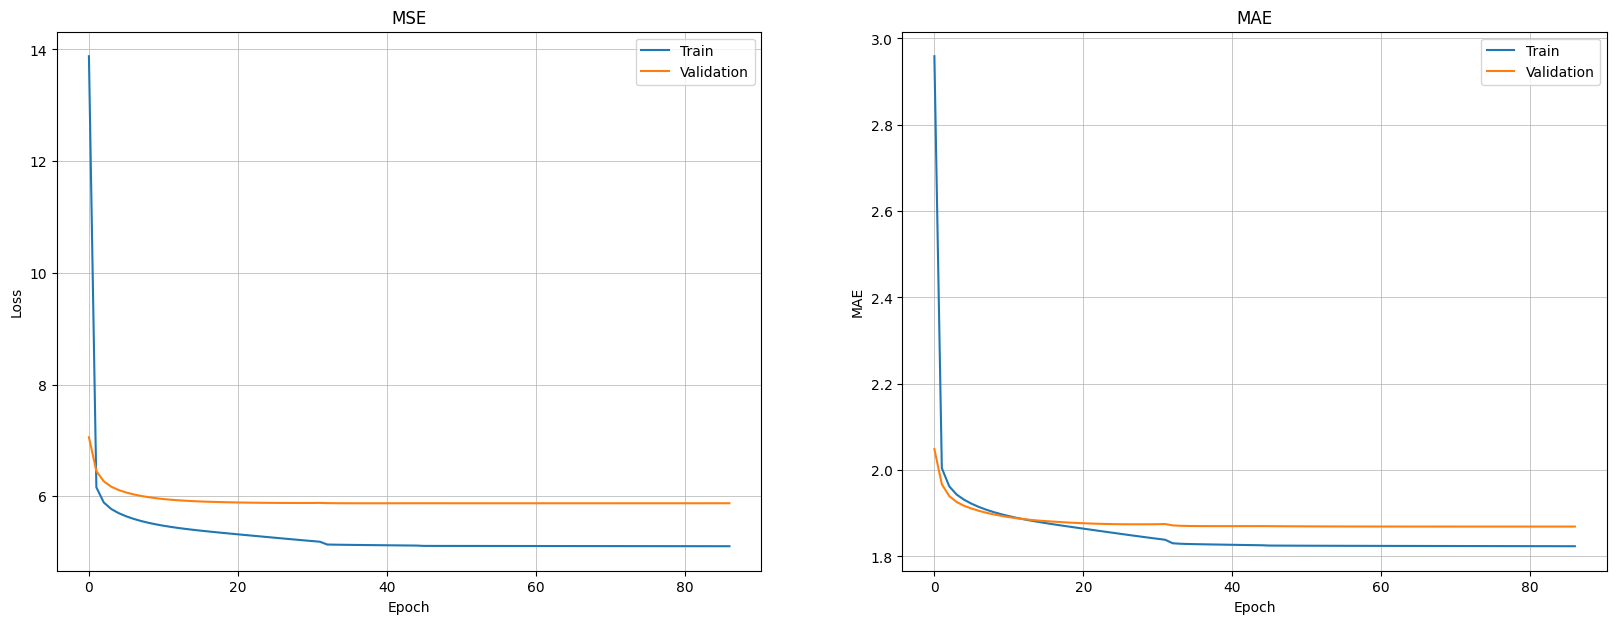

In [60]:
# 2 - Training
# ====================================
model, history = fit_model(model, verbose=1)

plot_history(history);

# 3 - Evaluation
# ====================================
res = model.evaluate(X_test, y_test)
print("-"*50)
print(f"The LSTM MAE on the test set is equal to {round(res[1],2)} km/h")

In [67]:
relative_path = os.path.dirname(current_dir)
models_folder = os.path.join(relative_path, "models/windspeed")

save_as_keras = os.path.join(models_folder, 'wind_speed_10m.keras')

In [69]:
model.save(save_as_keras)

## 4.2 Baseline

In [ ]:
def last_seen_value_baseline(X_test, y_test, target_column_idx=0):
    """
    Baseline model that predicts the last observed value of the target variable (snowfall).

    Parameters:
    X: Input features (shape: [num_samples, time_steps, num_features])
    y: Ground truth values (shape: [num_samples, time_steps, num_targets])
    target_column_idx: Index of the target variable in the input features

    Returns:
    baseline_mae: Mean Absolute Error (MAE) of the baseline model
    """
    # Get the last observed value of the target (temperature) for each sample
    last_seen_values = X_test[:, -1, target_column_idx].reshape(-1, 1)

    # Repeat this value for all the output steps
    output_length = y_test.shape[1]  # Number of time steps in the target sequence
    repeated = np.repeat(last_seen_values, axis=1, repeats=output_length)

    # Calculate the MAE: Mean of absolute errors
    mae = np.mean(np.abs(y_test - repeated))

    return mae

In [ ]:
# 1 - Evaluation of the Baseline Model
# ====================================
mae_baseline = last_seen_value_baseline(X_test, y_test, target_column_idx=0)
print(f"- The Baseline MAE on the test set is equal to {round(mae_baseline,2)} km/h")

# 4 - Comparison with the LSTM model
# ====================================
print(f"- The LSTM MAE on the test set is equal to {round(res[1],2)} cm")
print(f"👉 Improvement/decrease of the LSTM model over the baseline (on this fold for the test set): {round((1 - (res[1]/mae_baseline))*100,2)} % 👈")

## 4.3 Optimizing on Hyperparameters

In [ ]:
!pip install keras_tuner

In [ ]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperModel
from keras_tuner import RandomSearch

class LSTMModel(HyperModel):
    def build(self, hp):
        reg_l2 = regularizers.L2(hp.Float('l2_reg', min_value=0.001, max_value=0.1, step=0.001))

        #========================================================================================

        model = models.Sequential()

        # Input Layer
        model.add(layers.Input(shape=(X_train.shape[1], X_train.shape[2])))

        # Recurrent Layer with tunable units and dropout
        model.add(layers.LSTM(
            units=hp.Int('units', min_value=16, max_value=128, step=16),
            activation='tanh',
            return_sequences=True,
            recurrent_dropout=hp.Float('recurrent_dropout', min_value=0.2, max_value=0.5, step=0.05),
            dropout=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.05)
        ))
        model.add(layers.LSTM(
            units=hp.Int('units', min_value=16, max_value=128, step=16),
            activation='tanh',
            return_sequences=True,
            recurrent_dropout=hp.Float('recurrent_dropout', min_value=0.2, max_value=0.5, step=0.05),
            dropout=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.05)
        ))

        # Hidden Dense Layer with tunable regularization
        model.add(layers.Dense(
            units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
            activation="relu",
            kernel_regularizer=reg_l2
        ))
        model.add(layers.Dropout(rate=hp.Float('dense_dropout', min_value=0.2, max_value=0.5, step=0.05)))

        # Output Layer
        model.add(layers.Dense(1, activation='linear'))

        #========================================================================================

        # Compile the model
        model.compile(
            loss='mse',
            optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
            metrics=["mae"]
        )

        return model

In [ ]:
tuner = RandomSearch(
    LSTMModel(),  # The HyperModel class
    objective='val_mae',  # We want to minimize validation MAE
    max_trials=10,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to train per trial
    directory='models',  # Directory to store logs and models
    project_name='windspeed_hyperparameters')

tuner.search(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.3,  # Use a validation split
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=2)])

In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

# Build the best model with those hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5)]
)

# Evaluate the best model on the test set
test_results = best_model.evaluate(X_test, y_test)
print(f"Test MAE: {test_results[1]} km/h")

In [ ]:
plot_history(history);

# 4.4. Save/ Load model

In [ ]:
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras import models

In [ ]:
relative_path = os.path.dirname(current_dir)
models_folder = os.path.join(relative_path, "powder_alert2.0/models")

save_as_keras = os.path.join(models_folder, 'snowfall_FINAL.keras')

In [ ]:
best_model.save(os.path.join(relative_path, 'models/windspeed/wind_model.keras')) # save in keras compressed format
best_model.save(os.path.join(relative_path, 'models/windspeed/wind_model.h5') # save in h5 compressed format
best_model.save(os.path.join(relative_path, 'models/windspeed/wind_model', save_format='tf') # save in tf format, it should cr

In [ ]:
loaded_model_keras = tf.keras.models.load_model(save_as_keras)

# 5. Prediction

In [ ]:
last_input = X_test[-1:]
last_input.shape

In [ ]:
best_model = loaded_model_keras # needs to be changed to load the best/ current model --> best_model

In [ ]:
predictions = best_model.predict(last_input)

In [ ]:
predicted_temperatures = predictions[0]
print(f'The snowfall for the upcoming 24 h ranges from {predicted_temperatures.min()} to {predicted_temperatures.max()} km/h.')

In [ ]:
predicted_df = pd.DataFrame(predicted_temperatures, columns=["Predicted windspeed"])
predicted_df["Hour"] = pd.date_range(start=pd.to_datetime('now'), periods=24, freq='h')

# Plot the predicted temperatures
plt.figure(figsize=(10,6))
plt.plot(predicted_df["Hour"], predicted_df["Predicted windspeed"], marker='o')
plt.title("Predicted windspeed for the Next 24 Hours")
plt.xlabel("Hour")
plt.ylabel("cm")
plt.grid(True)
plt.xticks(rotation=45)
plt.show();